In [1]:
'''
Generation of news titles using LSTM
Data taken from: https://www.kaggle.com/datasets/rmisra/news-category-dataset/
Student: MATTIA COLBERTALDO
'''
# Packages
import pandas as pd
import pickle
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd 


1. (2 pt) Download data - Download the data and read it as pandas Dataframe.
Inspect the data and the columns. Filter only the news labeled with
POLITICS. At this point, you should have 35602 sequences. Print and
report here the first 3.

In [2]:

import os
print(os.listdir("./input"))

# Replace 'newscategory.json' with the actual file path or URL
data_path = './input/newscategory/News_Category_Dataset_v3.json'

# Read the data into the DataFrame
df_json = pd.read_json(data_path, lines=True)

df = pd.DataFrame(df_json)


# Inspect the data and columns
print("Data Overview:")
print(df.head())

# Filter only the news labeled with POLITICS
politics_df = df[df['category'] == 'POLITICS']

# Print and report the first 3 sequences
print("Print and report the first 3 sequences of POLITICS")
print(politics_df.head(3))

print("df shape:" , df.shape)
print("politics shape:", politics_df.shape)

['newscategory']
Data Overview:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfu

2. (3 pts) Tokenization - For each title, tokenize it at a word level and create
a list containing lists of words, one list for each title. Make sure to convert
all the words in lowercase. Append, at the end of each sentence, the
<EOS> token. As you may have noticed this procedure takes a lot of
time. Save the list you created in pickles the first time you properly create
it and load them for the next tests. Use pickle format. Read this if you
don’t know how to use it. Print and report here the first three sentences
tokenized.

In [3]:
%pip install nltk
import nltk
import re

nltk.download('punkt')

def tokenizer(text):
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if re.match('^[a-zA-Z]+$', word)]
    return filtered_words


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from nltk.tokenize import  word_tokenize
def split_to_words_and_save(df, column_name, pickle_filename):
    """
    Tokenize titles into words and append <EOS> token, then save to a pickle file.
    """
    EOS = "<EOS>"
    data = []

    # Extract titles from the specified column
    titles = df[column_name].str.lower().tolist()

    for title in titles:
        # Split titles into words, concatenate EOS, and append to the data list
        word_list = title.split() + [EOS]
        data.append(word_list)

    # Save tokenized data as a pickle file
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    return data

def load_tokenized_titles(pickle_filename):
    """
    Load tokenized titles from a pickle file and print the first three.
    """
    with open(pickle_filename, 'rb') as handle:
        tokenized_titles = pickle.load(handle)

    return tokenized_titles





        
data = split_to_words_and_save(politics_df, column_name='headline', pickle_filename='tokenized_titles.pkl')

tokenized_titles = load_tokenized_titles(pickle_filename='tokenized_titles.pkl')
# Print the first three tokenized sentences
print("First three tokenized sentences:")
for i in range(3):
    print(tokenized_titles[i])
print(len(tokenized_titles))

First three tokenized sentences:
['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>']
['‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival', 'takes', 'on', 'a', 'deeper', 'meaning', 'this', 'year', '<EOS>']
['biden', 'says', "queen's", 'death', 'left', "'giant", "hole'", 'for', 'royal', 'family', '<EOS>']
35602


3. (4 pts) Dictionaries - Create a list named all words containing all the
words exactly once and save it. As already done in Exercise 4, put at
position 0 the token <EOS> and at position -1 the token PAD. Create two
dictionaries named word to int and int to word representing a mapping from words (keys) to integer. At this point, you should have 33207
tokens. Save the dictionaries in pickle. Do this procedure just once.
Report here the most common 5 words.

In [5]:
from collections import Counter
import string
import re
from nltk.tokenize import word_tokenize

# Load tokenized titles
tokenized_titles = load_tokenized_titles(pickle_filename='tokenized_titles.pkl')

tokenized_titles = [' '.join(title) for title in tokenized_titles]
print(tokenized_titles[0:2])
print(len(tokenized_titles))

# Tokenize the titles at a word level and remove <EOS> token
tokenized_titles = [title.split() for title in tokenized_titles]
print(tokenized_titles[0:2])
print(len(tokenized_titles))

# Flatten the list of lists into a single list
tokenized_words = [word for title in tokenized_titles for word in title]# if word != '<EOS>']
print("Flattening the list of lists into a single list")
print(tokenized_words[0:21])
print(len(tokenized_words))

'''

# Convert all words to lowercase, remove punctuation and numbers
tokenized_words = [re.sub(r'\W+', '', word.lower()) for word in tokenized_words]
print("Convert all words to lowercase, remove punctuation and numbers")
print(tokenized_words[0:13])
print(len(tokenized_words))

# Remove non-alphanumeric words from tokenized_words
tokenized_words = [word for word in tokenized_words if re.match(r'^\w+$', word)]
print("Remove non-alphanumeric words from tokenized_words")
print(tokenized_words[0:13])
print(len(tokenized_words))

'''

# Count word frequencies
print("Number of words: ", len(tokenized_words))
word_counts = Counter(tokenized_words)
most_common_words = word_counts.most_common(6)

print("Most common 5 words:", most_common_words[1:6])  # Exclude <EOS>

# Remove duplicate words
tokenized_words = list(set(tokenized_words))
# Add <EOS> at the beginning
tokenized_words.remove('<EOS>')
tokenized_words.insert(0, '<EOS>')

# Add PAD at the end
tokenized_words.append('PAD')
print("Remove duplicate words")
print(tokenized_words[0:13])
print(len(tokenized_words))

# Append the <EOS> token to the end of each tokenized title
# tokenized_words = [title + ['<EOS>'] for title in tokenized_words]

print("Number of unique words: ", len(tokenized_words))

print(tokenized_words[0:13])
print(len(tokenized_words))

# Count word frequencies
print("Number of words: ", len(tokenized_words))
word_counts = Counter(tokenized_words)
most_common_words = word_counts.most_common(6)


# Save tokenized data as a pickle file
with open('tokenized_words.pkl', 'wb') as handle:
    pickle.dump(tokenized_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load tokenized titles
with open('tokenized_words.pkl', 'rb') as handle:
    tokenized_words = pickle.load(handle)



['biden says u.s. forces would defend taiwan if china invaded <EOS>', '‘beautiful and sad at the same time’: ukrainian cultural festival takes on a deeper meaning this year <EOS>']
35602
[['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>'], ['‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival', 'takes', 'on', 'a', 'deeper', 'meaning', 'this', 'year', '<EOS>']]
35602
Flattening the list of lists into a single list
['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>', '‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival']
400837
Number of words:  400837
Most common 5 words: [('to', 10701), ('the', 9619), ('trump', 6896), ('of', 5536), ('in', 5250)]
Remove duplicate words
['<EOS>', 'hillary,', 'accessed', "'protect'", 'vegetables', 'katrina,', "'worse", "dishonesty'", 'east:', 'constitution:', 'eager’', 'engaged', 

In [6]:

# Create dictionaries for word to int and int to word mapping
word_to_int = {}
int_to_word = {}
for i, word in enumerate(tokenized_words):
    if i == 0 or i == len(tokenized_words)-1:
        print(i, word)
    if i == len(tokenized_words):
        print(i, word)
    if len(word_to_int) != len(int_to_word):
        print(i-1, tokenized_words[i-1])
    int_to_word[i] = word
    word_to_int[word] = i
print(int_to_word[0])
print(word_to_int['<EOS>'])
print(int_to_word[len(tokenized_words)-1])
print(word_to_int['PAD'])
print(len(int_to_word))
print(len(word_to_int))

0 <EOS>
33206 PAD
<EOS>
0
PAD
33206
33207
33207


4. (5 pts) Dataset class - Create a dataset class taking as input your list of
tokenized sequences and the dictionary word to int. Each item should
be a tuple having as the first item the indexes of all the words of the sentence except the last one; the second one contains all the elements of that
sentence except the first one. Explain here what you need to implement.

In [7]:
import random
class Dataset(torch.utils.data.Dataset):
    def __init__(self, titles, word_to_int):
        self.data_as_int = []

        # Convert characters to integers
        for title in titles:
            seq_as_int = [word_to_int[word] for word in title]
            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]

        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)
print(tokenized_titles[0:50])
dataset = Dataset(tokenized_titles, word_to_int)
print("Dataset length:", len(dataset))
print("Dataset first element:", dataset.__getitem__(0))
print("Dataset last element:", dataset[-1])
print(len(word_to_int))
print(word_to_int['<EOS>'])
print(word_to_int['PAD'])
print(int_to_word[len(word_to_int)-1])


[['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>'], ['‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival', 'takes', 'on', 'a', 'deeper', 'meaning', 'this', 'year', '<EOS>'], ['biden', 'says', "queen's", 'death', 'left', "'giant", "hole'", 'for', 'royal', 'family', '<EOS>'], ['bill', 'to', 'help', 'afghans', 'who', 'escaped', 'taliban', 'faces', 'long', 'odds', 'in', 'the', 'senate', '<EOS>'], ['mark', 'meadows', 'complies', 'with', 'justice', 'dept.', 'subpoena:', 'report', '<EOS>'], ['democrats', 'nominate', 'seth', 'magaziner', 'in', 'key', 'rhode', 'island', 'house', 'race', '<EOS>'], ['joe', 'biden', 'urges', 'national', 'unity', 'in', 'speech', 'on', 'renewed', '‘cancer', 'moonshot’', '<EOS>'], ['sen.', 'tim', 'scott', 'downplays', 'electability', 'concerns', 'over', 'struggling', 'senate', 'gop', 'candidates', '<EOS>'], ['electability', 'is', 'on', 'the', 'ballot', 'in', 'key', 'rhode', 'i

5. (6 pts) Padding, Batches, Dataloader- Define a function collate fn(batch)
that pads sequences with PAD until the maximum sequence size of the
batch. Then, create a Dataloader that autonomously to the padding using collate fn. Although an analogous task has been performed in
Exercise 4, you can read more on this here. Explain here what you need
to implement.


In [8]:
def collate_fn(batch, pad_value):
  data, targets = zip(*batch)

  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True,
                                          padding_value=pad_value)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True,
                                             padding_value=pad_value)

  return padded_data, padded_targets

In [9]:
batch_size = 64
dataset = Dataset(tokenized_titles, word_to_int)
if batch_size == 1:
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
  dataloader = DataLoader(dataset, batch_size=batch_size,
                          collate_fn=lambda b: collate_fn(b, word_to_int["PAD"]),
                          shuffle=True)

1.2 Model definition (20 points)
Define your model. It must be an LSTM-based model where you can add whatever you like. Two things are mandatory:
• Having an Embedding at the beginning,
• Using LSTM, potentially stacked.
Apart from that, you can add Dropout, fully connected layers, and whatever
comes to your mind. To get full marks, motivate your choice. Note: transfer
learning is not allowed
Don’t forget to define a method named init state to define the initial
state. What is the main difference with RNNs?


In [10]:
# @title TO-DO 3 (solution)
class Model(nn.Module):
    def __init__(self, map, hidden_size, emb_dim=50, n_layers=2, dropout_p=0.2):
        super(Model, self).__init__()

        self.vocab_size  = len(map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p

        # dimensions: batches x seq_length x emb_dim
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim,
            padding_idx=map["PAD"])

        self.lstm = nn.LSTM(input_size=self.emb_dim,
                   hidden_size=self.hidden_size,
                   num_layers=self.n_layers,
                   batch_first=True)

        self.dropout = nn.Dropout(self.dropout_p)

        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)

    def forward(self, x, prev_state):
        x = x.long()
        embed = self.embedding(x)
        #print("Embedding shape:", embed.shape)  # Add this line
        yhat, state = self.lstm(embed, prev_state)   # yhat is the full sequence prediction, while state is the last hidden state (coincides with yhat[-1] if n_layers=1)

        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state

    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size).cuda(),
                torch.zeros(self.n_layers, b_size, self.hidden_size).cuda())

In [11]:
def random_sample_next(model, x, prev_state, topk=5, uniform=True):
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]    # vocabulary values of last element of sequence

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)

    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).cpu().numpy()
    sampled_ix = np.random.choice(top_ix.cpu().numpy(), p=p)
    
    return sampled_ix, state

In [12]:
def sample_argmax(model, x, prev_state):
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]    # vocabulary values of last element of sequence

    # Get the index of the maximum value
    sampled_ix = torch.argmax(last_out).item()
    
    return sampled_ix, state

In [13]:

def sample(model, prompt, max_length, seed, sampling, device):
    seed = seed if isinstance(seed, (list, tuple)) else [seed]
    model.eval()

    # Convert the prompt to a tensor
    prompt_tensor = torch.tensor([word_to_int[word] for word in prompt], dtype=torch.long).unsqueeze(0).cuda()

    # Initialize the hidden state
    h, c = model.init_state(b_size=1)
    
    # Generate the sentence
    generated_sentence = list(prompt)

    with torch.no_grad():
        sampled_ix_list = seed[:]
        for _ in range(max_length):
            # Forward pass
            #output, (h, c) = model(prompt_tensor, (h, c))

            if sampling == 'topk':
                sampled_ix, (h,c) = random_sample_next(model, prompt_tensor, (h,c), topk=5, uniform=True) #torch.max(output[:, -1, :], dim=1)
            elif sampling == 'argmax':
                sampled_ix, (h,c) = sample_argmax(model, prompt_tensor, (h,c))
            else:
                raise ValueError('Sampling strategy not recognized: ' + sampling)
            sampled_ix_list.append(sampled_ix)

            # Append the next word to the generated sentence
            next_word = int_to_word[sampled_ix]
            generated_sentence.append(next_word)

            # Update the prompt tensor for the next iteration
            prompt_tensor = torch.tensor([word_to_int[word] for word in generated_sentence], dtype=torch.long).unsqueeze(0).cuda()
            #prompt_tensor = torch.tensor([word_to_int[next_word]], dtype=torch.long).unsqueeze(0).cuda()
            
            if next_word == '<EOS>':
                break

    return ' '.join(generated_sentence)

In [14]:
def train(model, data, num_epochs, criterion, lr=0.001, print_every=1, seed= 1, clip=1, sampling='topk'):
    model.train()

    costs = []
    running_loss = 0
    loss_hist = []
    perplexities = []
    sentences = []

    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch = 0
    while epoch<num_epochs:
        epoch += 1
        model.train()
        for x, y in data:
            x , y = x.cuda(), y.cuda().long()
            optimizer.zero_grad()
            # Initialise model's state and perform forward-prop
            prev_state = model.init_state(b_size=x.shape[0])
            out, state = model(x, prev_state)         # out has dim: batch x seq_length x vocab_size

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)  #transpose is required to obtain batch x vocab_size x seq_length
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if print_every and (epoch%print_every)==0:
            print("Epoch: {}/{}, Loss: {:8.4f}".format(
                        int(epoch), int(num_epochs),
                        running_loss/float(print_every*len(data))))
            loss_hist.append(running_loss/float(print_every*len(data)))
            perplexities.append(np.exp(running_loss/float(print_every*len(data))))
            running_loss = 0
        
        model.eval()
        # TODO prompt a sentence from the model
        generated_sentence = sample(model, ["the", "war", "will"], max_length=10, seed=seed, sampling=sampling, device="cuda")
        print("Generated Sentence:", generated_sentence)
        sentences.append(generated_sentence)

    return model, loss_hist, perplexities, sentences

In [15]:
def train_with_TBBTT(max_epochs, model, dataloader, criterion, optimizer, chunk_size, device, seed=1, clip=1, sampling='topk'):
    losses = []
    perplexities = []
    epoch = 0
    loss = 0
    running_loss = 0
    costs = []
    sentences = []
    while epoch < max_epochs:
        epoch += 1
        model.train()
        for input, output in dataloader:
            input = input.to(device)
            output = output.to(device)
            # Get the number of chunks
            n_chunks = input.shape[1] // chunk_size
            #print("X shape:", input.shape)
            #print("Y shape:", output.shape)
            #print("num chunks:", n_chunks)

            # Loop on chunks
            for j in range(n_chunks):
                # TODO what is missing here?
                optimizer.zero_grad()
                # Switch between the chunks
                if j < n_chunks - 1:
                    input_chunk = input[:, j * chunk_size:(j + 1) * chunk_size].to(device).to(torch.int64)
                    output_chunk = output[:, j * chunk_size:(j + 1) * chunk_size].to(device).to(torch.int64)
                else:
                    input_chunk = input[:, j * chunk_size:].to(device).to(torch.int64)
                    output_chunk = output[:, j * chunk_size:].to(device).to(torch.int64)
                # Initialise model's state and perform forward pass
                # If it is the first chunk, initialise the state to 0
                if j == 0:
                    h, c = model.init_state(b_size=input_chunk.shape[0])
                else:  # Initialize the state to the previous state - detached!
                    h, c = h.detach(), c.detach()

                # Forward step
                # TODO: complete the forward step
                out, (h, c) = model(input_chunk, (h, c))

                # Calculate loss
                # TODO complete the loss calculation
                loss = criterion(out.transpose(1, 2), output_chunk)
                running_loss += loss.item()

                # Calculate gradients and update parameters
                # TODO: complete the backward step
                optimizer.zero_grad()
                loss.backward()
                
                # Clipping if needed
                # TODO: complete the clipping step
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(), clip)
                # Update parameters
                # TODO: complete the update step
                optimizer.step()
                costs.append(loss.item())
        losses.append(running_loss/float(len(dataloader)))
        perplexity = torch.exp(torch.mean(torch.tensor(costs))).item()
        perplexities.append(perplexity)
        print(f"Epoch: {epoch}/{max_epochs}, Loss: {losses[-1]:.4f}, Perplexity: {perplexity:.4f}")
        running_loss = 0

        model.eval()
        # TODO prompt a sentence from the model
        generated_sentence = sample(model, ["the", "war", "will"], max_length=10, seed=seed, sampling=sampling, device="cuda")
        sentences.append(generated_sentence)
        print("Generated Sentence:", generated_sentence)        

    return model, losses, perplexities, sentences

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
model = Model(word_to_int, hidden_size=1024, emb_dim=150, n_layers=2, dropout_p=0.2)
model = model.cuda()
batch_size = 64
n_epochs = 12
seed = random.choice(list(word_to_int.values())[1:-1])
sampling='argmax'
model, losses, perplexities, sentences_train = train(model, dataloader, 12, criterion, lr=1e-3, print_every=1, seed=seed, clip=1, sampling=sampling)
model_train = model

Epoch: 1/12, Loss:   7.1851
Generated Sentence: the war will be a new york <EOS>
Epoch: 2/12, Loss:   6.2042
Generated Sentence: the war will be a big <EOS>
Epoch: 3/12, Loss:   5.4738
Generated Sentence: the war will be the most thing <EOS>
Epoch: 4/12, Loss:   4.6173
Generated Sentence: the war will be a president <EOS>
Epoch: 5/12, Loss:   3.6160
Generated Sentence: the war will be the next president <EOS>
Epoch: 6/12, Loss:   2.7048
Generated Sentence: the war will be our friends <EOS>
Epoch: 7/12, Loss:   2.0094
Generated Sentence: the war will be our human rights <EOS>
Epoch: 8/12, Loss:   1.4974
Generated Sentence: the war will be our prison <EOS>
Epoch: 9/12, Loss:   1.1473
Generated Sentence: the war will be our president <EOS>
Epoch: 10/12, Loss:   0.9314
Generated Sentence: the war will be our president <EOS>
Epoch: 11/12, Loss:   0.8134
Generated Sentence: the war will be our president <EOS>
Epoch: 12/12, Loss:   0.7568
Generated Sentence: the war will be our same? <EOS>


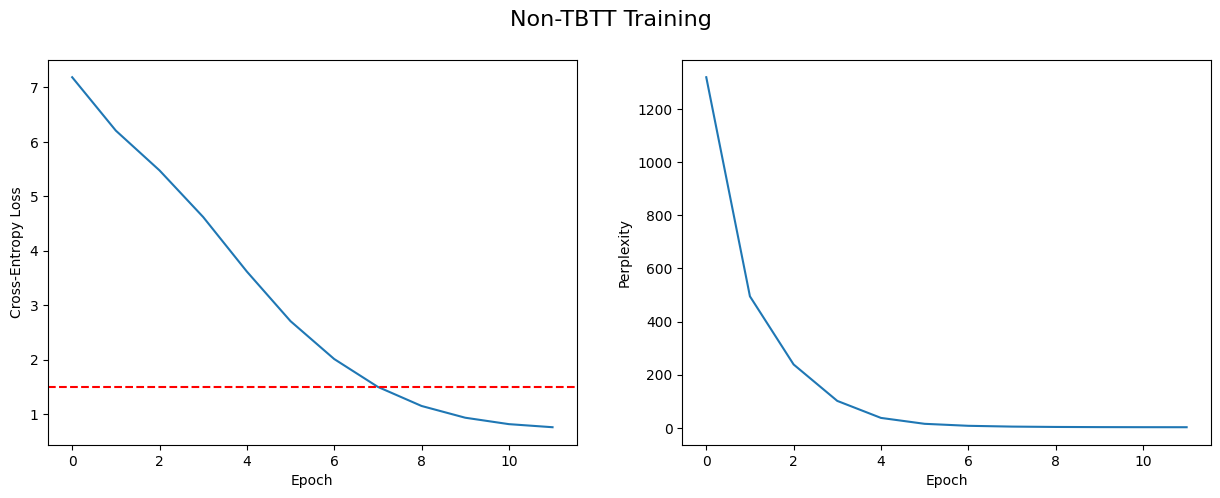

In [20]:
losses_train = losses
perplexities_train = perplexities

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Non-TBTT Training", fontsize=16)

ax[0].plot(np.array(losses))
ax[0].set(xlabel="Epoch", ylabel="Cross-Entropy Loss")
ax[1].plot(np.array(perplexities))
ax[1].set(xlabel="Epoch", ylabel="Perplexity")
ax[0].axhline(y=1.5, color='r', linestyle='--')

In [21]:
print("Generated sentence after the first epoch: ", sentences_train[0])
print("Generated sentence in the middle of training: ", sentences_train[len(sentences_train)//2])
print("Generated sentence after the last epoch: ", sentences_train[-1])

Generated sentence after the first epoch:  the war will be a new york <EOS>
Generated sentence in the middle of training:  the war will be our human rights <EOS>
Generated sentence after the last epoch:  the war will be our same? <EOS>


1.5 Evaluation - part 2 (5 points)
Generate and report 2/3 sentences in the following way:
• Start with any prompt, e.g, “the president wants”, and generate three
sentences with sampling strategy.
• Start with the same prompt as above and generate three sentences with
the greedy strategy.
What do you notice?
Do you think your titles are credible? Try submitting the best titles you get
to some friends or colleagues along with other titles taken from the dataset.
Note: harmful content may be generated from your architecture. Reporting
them here will lead to a score of 0 on the full assignment.

In [22]:
criterion = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
model = Model(word_to_int, hidden_size=2048, emb_dim=150, n_layers=1, dropout_p=0)
model = model.cuda()
batch_size = 64
n_epochs = 7
seed = random.choice(list(word_to_int.values())[1:-1])
sampling='argmax'
model, losses, perplexities, sentences_tbtt = train_with_TBBTT(n_epochs, model, dataloader, criterion, 
                                            optim.Adam(model.parameters(), lr=0.001), chunk_size=10, device='cuda', seed=seed, clip=1, sampling=sampling)

Epoch: 1/7, Loss: 7.6626, Perplexity: 914.1338
Generated Sentence: the war will be a big <EOS>
Epoch: 2/7, Loss: 6.0508, Perplexity: 448.4575
Generated Sentence: the war will be the next president <EOS>
Epoch: 3/7, Loss: 4.4287, Perplexity: 220.9732
Generated Sentence: the war will the supreme court <EOS>
Epoch: 4/7, Loss: 2.8311, Perplexity: 107.4011
Generated Sentence: the war will be our next president <EOS>
Epoch: 5/7, Loss: 1.6616, Perplexity: 56.6570
Generated Sentence: the war will be our own president <EOS>
Epoch: 6/7, Loss: 1.0259, Perplexity: 33.6906
Generated Sentence: the war will the gop miss the war <EOS>
Epoch: 7/7, Loss: 0.8040, Perplexity: 22.5911
Generated Sentence: the war will not be ready <EOS>


In [23]:
print("Generated sentence after the first epoch: ", sentences_tbtt[0])
print("Generated sentence in the middle of training: ", sentences_tbtt[len(sentences_tbtt)//2])
print("Generated sentence after the last epoch: ", sentences_tbtt[-1])

Generated sentence after the first epoch:  the war will be a big <EOS>
Generated sentence in the middle of training:  the war will be our next president <EOS>
Generated sentence after the last epoch:  the war will not be ready <EOS>


In [30]:
model.eval()
prompts = [["biden", "thinks"], ["the", "future"], ["today"]]
for prompt in prompts:
    for _ in range(3):
        generated_sentence = sample(model, prompt, max_length=10, seed=seed, sampling='argmax', device="cuda")
        print("Generated Sentence:", generated_sentence)

    for _ in range(3):
        generated_sentence = sample(model, prompt, max_length=10, seed=seed, sampling='topk', device="cuda")
        print("Generated Sentence:", generated_sentence)

Generated Sentence: biden thinks he will face trump <EOS>
Generated Sentence: biden thinks he will face trump <EOS>
Generated Sentence: biden thinks he will face trump <EOS>
Generated Sentence: biden thinks trump's army tax nominee report he was no <EOS>
Generated Sentence: biden thinks his refugee run <EOS>
Generated Sentence: biden thinks his death is just days guys <EOS>
Generated Sentence: the future of the democratic party <EOS>
Generated Sentence: the future of the democratic party <EOS>
Generated Sentence: the future of the democratic party <EOS>
Generated Sentence: the future is "nasty" of ebola nurse are the most attention of
Generated Sentence: the future is about to go back the wrong why you <EOS>
Generated Sentence: the future of elections by the islamic armed movement of our time'
Generated Sentence: today is clinton’s chance <EOS>
Generated Sentence: today is clinton’s chance <EOS>
Generated Sentence: today is clinton’s chance <EOS>
Generated Sentence: today is now <EOS>


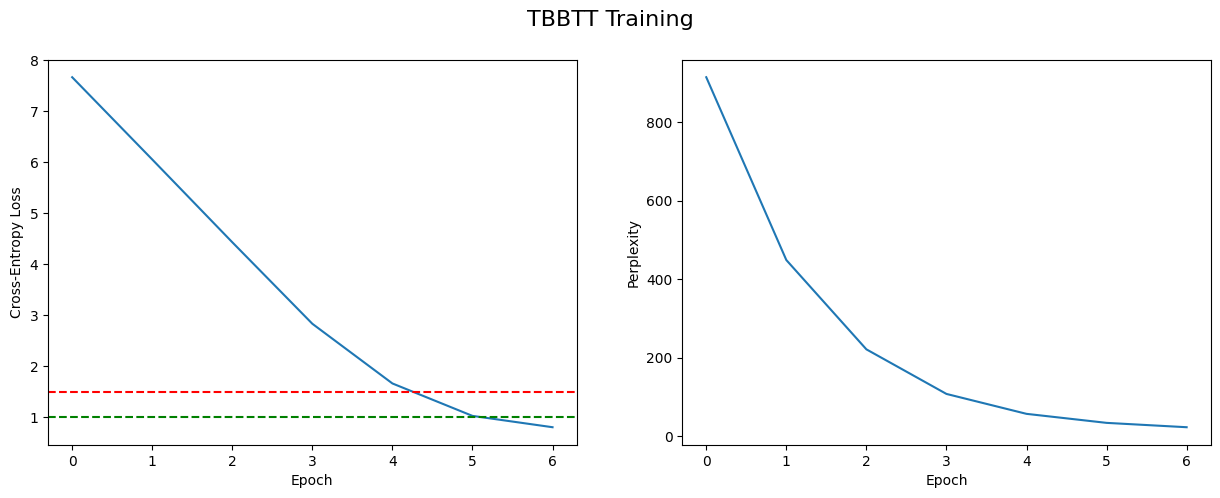

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("TBBTT Training", fontsize=16)

ax[0].plot(np.array(losses))
ax[0].set(xlabel="Epoch", ylabel="Cross-Entropy Loss")
ax[1].plot(np.array(perplexities))
ax[1].set(xlabel="Epoch", ylabel="Perplexity")

ax[0].axhline(y=1.5, color='r', linestyle='--')
ax[0].axhline(y=1.0, color='g', linestyle='--')

In [31]:

model = model.to('cpu')
king = torch.tensor(word_to_int['king'])
king = model.embedding(king)
man = torch.tensor(word_to_int['man'])
man= model.embedding(man)
woman = torch.tensor(word_to_int['woman'])
woman = model.embedding(woman)
queen = torch.tensor(word_to_int['queen'])
queen= model.embedding(queen)
result = (king-man+woman)
l2 = torch.norm(queen - result, p=2).item()
print('L2 distance with queen: ',l2 )

l2_queen = l2
bestL2 = l2
list_l2 = []
best_word = 'Queen'.lower()
for word in word_to_int:
    tensor = torch.tensor(word_to_int[word])
    tensor = model.embedding(tensor)
    l2 = torch.norm(tensor - result, p=2).item()
    list_l2.append((l2,word))
    if l2 < bestL2:
        bestL2 = l2
        best_word=word
list_l2_sorted = sorted(list_l2, key = lambda x: x[0])  
print(list_l2_sorted[:10])
print('Result: ', best_word)
print('with L2 distance: ',bestL2 )
#print('Queen is the ', list_l2_sorted.index((l2_queen, 'queen'))+1, 'th most similar word')

L2 distance with queen:  23.54176902770996
[(17.283414840698242, 'king'), (18.60950469970703, 'woman'), (21.155622482299805, 'pay'), (21.329944610595703, 'trade:'), (21.39019012451172, "secretary's"), (21.39341163635254, 'underestimate'), (21.408870697021484, 'inherits'), (21.41746711730957, 'much-touted'), (21.482872009277344, 'lambasts'), (21.50606346130371, 'boggs,')]
Result:  king
with L2 distance:  17.283414840698242
